## Prerequisites

### Load Qiskit and Required Libraries

In [1]:
from qiskit import IBMQ, transpile, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import IGate, XGate, YGate, ZGate
from qiskit.pulse import DriveChannel
import qiskit.quantum_info as qi

from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import TemplateOptimization, ALAPSchedule, DynamicalDecoupling
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder, rzx_templates

from qiskit.opflow import I, X, Y, Z

from qiskit.scheduler.config import ScheduleConfig
from qiskit.visualization import plot_circuit_layout, plot_error_map, timeline_drawer

from copy import deepcopy
import numpy as np
import scipy.linalg as lng
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [5, 5]

### Load IBM Quantum Account

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='mission-critical', project='bronn')
backend = provider.get_backend('ibm_lagos')

### Load Backend Information (for Pulse Scaling)

In [3]:
backend_config = backend.configuration()
#dt = backend_config.dt
#meas_map = backend_config.meas_map

backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

#sched_config = ScheduleConfig(inst_sched_map, meas_map, dt)

# Construct Circuit

## Say Ising-type Circuit 

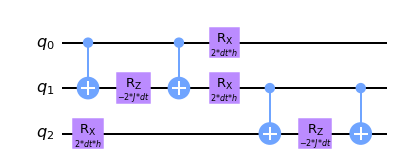

In [4]:
JJ = Parameter('$J$') # exchange coupling strength
hh = Parameter('$h$') # transverse magnetic field
dt = Parameter('$dt$') # Trotter step size
TT = Parameter('$T$') # total time

qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.rz(-2*JJ*dt, 1)
qc.cx(0, 1)
qc.rx(2*hh*dt, [0, 1, 2])
qc.cx(1, 2)
qc.rz(-2*JJ*dt, 2)
qc.cx(1, 2)
qc.draw(output='mpl')

# Map Abstract Circuit to Physical Layout: VF2Layout

This uses a very fast classical algorithm for the subgraph isomorphism problem to find an optimal layout (when coupled with the following code that optimizes based on a *useful* device error metric).

In [5]:
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes import VF2Layout, CSPLayout # VF2Layout only in current dev branch

## Find best layout based on readout error

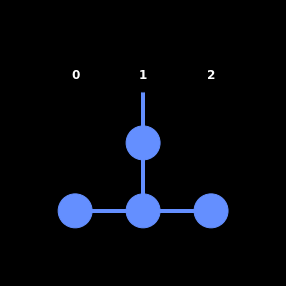

In [6]:
cm = backend_config.coupling_map
vf2_pass = VF2Layout(CouplingMap(cm), properties=backend.properties()) # this is stupid, only uses readout error
vf2_transpiled = vf2_pass(qc)
plot_circuit_layout(vf2_transpiled, backend, view='physical')

In [7]:
# this should probably be a method in Qiskit
# probably need to address the name of the QuantumRegister
from qiskit.circuit import Qubit, QuantumRegister

def get_mapped_layout(qc, qc_t):
    mapped_layout = []
    for qidx in range(qc.num_qubits):
        mapped_layout.append(qc_t._layout.get_virtual_bits()[Qubit(QuantumRegister(qc.num_qubits, 'q'), qidx)])
        
    return mapped_layout

## Get best layout based on CNOT error

Seed 0: Avg 2-qubit gate error is 0.00815836612674413
[2, 1, 0]


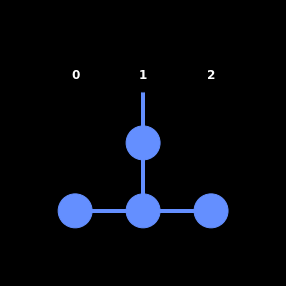

In [9]:
lowest_error = 1
best_qc_t = qc
for seed in range(1000):
    vf2_pass = VF2Layout(CouplingMap(cm), seed=seed)
    vf2_transpiled = vf2_pass(qc)
    mapped_layout = get_mapped_layout(qc, vf2_transpiled)
    avg_gate_error = 0
    for ii in range(len(mapped_layout)-1):
        q0 = mapped_layout[ii]
        q1 = mapped_layout[ii+1]
        avg_gate_error += backend.properties().gate_property('cx')[(q0, q1)]['gate_error'][0]

    avg_gate_error /= len(mapped_layout)-1
    if avg_gate_error < lowest_error:
        lowest_error = avg_gate_error
        best_qc_t = vf2_transpiled
        print('Seed '+str(seed)+': Avg 2-qubit gate error is '+str(avg_gate_error))
        
print(get_mapped_layout(qc, best_qc_t))
plot_circuit_layout(best_qc_t, backend, view='physical')

## Get best layout based on $T_1$ (or $T_2$)

Seed 0: Avg coherence is 117 us
[2, 1, 0]


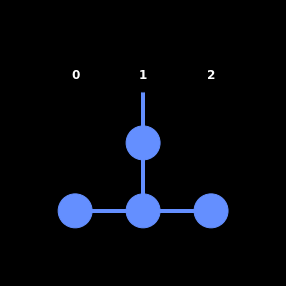

In [12]:
coho = 'T1' # or 'T2'
highest_coho = 0
best_qc_t = qc
for seed in range(1000): # excessive
    vf2_pass = VF2Layout(CouplingMap(cm), seed=seed)
    vf2_transpiled = vf2_pass(qc)
    mapped_layout = get_mapped_layout(qc, vf2_transpiled)
    avg_coho = 0
    for qubit in mapped_layout:
        avg_coho += backend.properties().qubit_property(qubit)[coho][0]*1e6 # us

    avg_coho /= len(mapped_layout)
    if avg_coho > highest_coho:
        highest_coho = avg_coho
        best_qc_t = vf2_transpiled
        print('Seed '+str(seed)+': Avg coherence is %.0f us' % avg_coho)
        
print(get_mapped_layout(qc, best_qc_t))
plot_circuit_layout(best_qc_t, backend, view='physical')

In [13]:
# we should be able to just use the transpiled circuit
# instead of explicitly asking for the layout
initial_layout = get_mapped_layout(qc, best_qc_t)

# Pulse Scaling

Of course this won't work with unbound `Parameter`s until Nick's Terra [PR #6899](https://github.com/Qiskit/qiskit-terra/pull/6899) is merged.

In [14]:
pass_ = TemplateOptimization(**rzx_templates.rzx_templates()) 
scaled_qc_t = PassManager(pass_).run(best_qc_t)

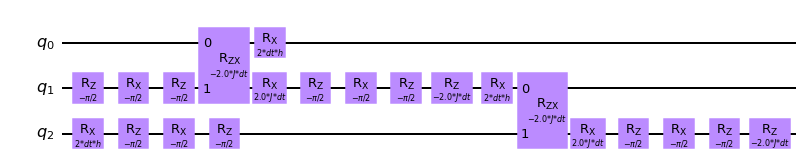

In [17]:
scaled_qc_t.draw(output='mpl', idle_wires=False)

## Template Optimization Issue

Some of these Pulse scaling procedures fail due to Terra Issue [#6974](https://github.com/Qiskit/qiskit-terra/issues/6974), where Nick has the following workaround below. Additional transpilation steps may be necessary for combining consecutive gates that contain `Parameter`s, in which case Nick has code that does that or it has been fixed by Terra PR [#7309](https://github.com/Qiskit/qiskit-terra/pull/7309).

## "Forced" CNOT-RZ-CNOT Optmization Workaround

In [14]:
from qiskit.dagcircuit import DAGCircuit, DAGNode, DAGOpNode

def get_zz_temp_sub() -> QuantumCircuit:
    rzx_dag = circuit_to_dag(deepcopy(rzx_templates.rzx_templates(['zz3'])['template_list'][0]))
    temp_cx1_node = rzx_dag.front_layer()[0]
    for gp in rzx_dag.bfs_successors(temp_cx1_node):
        if gp[0] == temp_cx1_node:
            if isinstance(gp[1][0].op, CXGate) and isinstance(gp[1][1].op, RZGate):
                temp_rz_node = gp[1][1]
                temp_cx2_node = gp[1][0]

                rzx_dag.remove_op_node(temp_cx1_node)
                rzx_dag.remove_op_node(temp_rz_node)
                rzx_dag.remove_op_node(temp_cx2_node)
    
    return dag_to_circuit(rzx_dag).inverse()

def sub_zz_in_dag(dag: DAGCircuit, cx1_node: DAGNode, rz_node: DAGNode, cx2_node: DAGNode) -> DAGCircuit:
    zz_temp_sub = get_zz_temp_sub().assign_parameters({get_zz_temp_sub().parameters[0]: rz_node.op.params[0]})
    dag.remove_op_node(rz_node)
    dag.remove_op_node(cx2_node)
    
    qr = QuantumRegister(2, 'q')
    mini_dag = DAGCircuit()
    mini_dag.add_qreg(qr)
    for idx, (instr, qargs, cargs) in enumerate(zz_temp_sub.data):
        mini_dag.apply_operation_back(instr, qargs=qargs)

    dag.substitute_node_with_dag(node=cx1_node, input_dag=mini_dag, wires=[qr[0], qr[1]])
    return dag

def forced_zz_temp_sub(dag: DAGCircuit) -> DAGCircuit:
    cx_runs = dag.collect_runs('cx')
    for run in cx_runs:
        cx1_node = run[0]
        gp = next(dag.bfs_successors(cx1_node))
        if isinstance(gp[0].op, CXGate): # dunno why this is needed
            if isinstance(gp[1][0], DAGOpNode) and isinstance(gp[1][1], DAGOpNode):
                if isinstance(gp[1][0].op, CXGate) and isinstance(gp[1][1].op, RZGate):
                    rz_node = gp[1][1]
                    cx2_node = gp[1][0]
                    gp1 = next(dag.bfs_successors(rz_node))
                    if cx2_node in gp1[1]:
                        if ((cx1_node.qargs[0].index == cx2_node.qargs[0].index) and
                            (cx1_node.qargs[1].index == cx2_node.qargs[1].index) and
                            (cx2_node.qargs[1].index == rz_node.qargs[0].index)):

                            dag = sub_zz_in_dag(dag, cx1_node, rz_node, cx2_node)

    return dag

<ipython-input-14-cc4195549a55>:44: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if ((cx1_node.qargs[0].index == cx2_node.qargs[0].index) and
<ipython-input-14-cc4195549a55>:45: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  (cx1_node.qargs[1].index == cx2_node.qargs[1].index) and
<ipython-input-14-cc4195549a55>:46: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  (cx2_node.qargs[1].index == rz_node.qargs[0].index)):


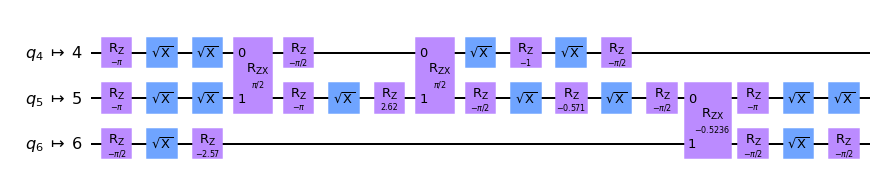

In [15]:
from qiskit.circuit.library import CXGate, RZGate
from qiskit.converters import circuit_to_dag, dag_to_circuit

scaled_qcs_t_f = []
for circ in scaled_qcs_t:
    dag = circuit_to_dag(circ)
    dag = forced_zz_temp_sub(dag)
    circ = dag_to_circuit(dag)
    scaled_qcs_t_f.append(transpile(circ, backend, basis_gates=['sx', 'rz', 'rzx']))
    #scaled_qcs_t_f.append(circ)

scaled_qcs_t_f[2].draw(output='mpl', idle_wires=False)

Arghhh... this one still's not working!

# Pauli Twirling

This should suppress dynamical $ZZ$ (based on transmon/CR physics). We will focus on the case with the $R_{ZZ}(\theta)$ scaled cross resonance, in which elements from the set $\mathbb{G} = \{[I, I], [X, X], [Y, Y], [Z, Z]\}$ are placed both before and after the $R_{ZZ}$ since the resulting operators commute. <br>

~Nick thinks it should be easy to find a different set $\mathbb{G}$ for the $R_{ZX}$ scaled pulses found from template optimization, then write a transpiler pass that generates a circuit sampled by each pair of Pauli's. In this case, we should actually implement Pauli twirling *after* Pulse scaling.~ This is done now below. <br>

Someone [thought about this](https://github.com/Qiskit/qiskit-experiments/issues/482) for Qiskit Experiments, but apparently not too long.

## Convert Twirl Gates to $R_{ZX}$

In [28]:
# sanity to make sure we converted valid twirls
twirl_op = Z^X

twirls = [I^I, X^Z, Y^Y, Z^X]
for twirl in twirls:
    print((twirl @ twirl_op @ twirl) == twirl_op)

True
True
True
True


In [ ]:
twirl_gates = [[IGate(), IGate()],
               [XGate(), ZGate()],
               [YGate(), YGate()],
               [ZGate(), XGate()]]

## Convert Circuits to DAGs for Transpilation

In [ ]:
dag = circuit_to_dag(scaled_qcs_t_f)
dag_drawer(dag)

## Twirl all $R_{ZX}$'s in DAG

In [ ]:
def twirl_rzx_gates(dag: DAGCircuit) -> list:
    twirled_dags = []
    for twirls in twirl_gates:
        this_dag = deepcopy(dag)
        runs = this_dag.collect_runs(['rzx'])
        for run in runs:
            mini_dag = DAGCircuit()
            p = QuantumRegister(2, 'p')
            mini_dag.add_qreg(p)
            mini_dag.apply_operation_back(twirls[0], qargs=[p[0]])
            mini_dag.apply_operation_back(twirls[1], qargs=[p[1]])
            mini_dag.apply_operation_back(run[0], qargs=[p[0], p[1]]) # this seems to work over using qargs
            mini_dag.apply_operation_back(twirls[0], qargs=[p[0]])
            mini_dag.apply_operation_back(twirls[1], qargs=[p[1]])

            rzx_node = this_dag.op_nodes(op=RZXGate).pop()
            this_dag.substitute_node_with_dag(node=rzx_node, input_dag=mini_dag, wires=[p[0], p[1]])

        twirled_dags.append(deepcopy(this_dag))
        
    return twirled_dags

In [ ]:
dags = twirl_rzx_gates(dag)
dag_drawer(dags[1])

TODO: Check circuit equivalence for sanity.

# Add Final Circuit Info

Currently we cannot really go past this in terms of leaving unbound `Parameter`s.

## Bind Parameters

In [16]:
param_bind = {JJ: 0.5236, hh: 1, dt: 0.5}
for circ in scaled_qcs_t_f:
    circ.assign_parameters(param_bind, inplace=True)

## Add Calibrations for $R_{ZX}(\theta)$

In [17]:
pass_ = RZXCalibrationBuilder(backend)
sca_circs_t = []
for circ in scaled_qcs_t_f:
    rzx_circ = PassManager(pass_).run(circ)
    sca_circs_t.append(rzx_circ)

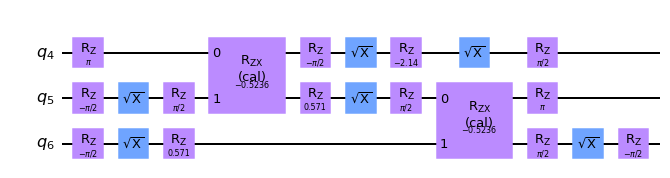

In [18]:
sca_circs_t[-1].draw(output='mpl', idle_wires=False)

# Dynamical Decoupling

## Manually Load Timing Info

Nick feels this should be done by Qiskit.

In [19]:
inst_durs = []

# single qubit gates
for qubit in range(backend_config.num_qubits):
    for inst_str in inst_sched_map.qubit_instructions(qubits=[qubit]):
        inst = inst_sched_map.get(inst_str, qubits=[qubit])
        inst_durs.append((inst_str, qubit, inst.duration))
        if inst_str == 'x':
            inst_durs.append(('y', qubit, inst.duration))

# two qubit gates
for qc in range(backend_config.num_qubits):
    for qt in range(backend_config.num_qubits):
        for inst_str in inst_sched_map.qubit_instructions(qubits=[qc, qt]):
            inst = inst_sched_map.get(inst_str, qubits=[qc, qt])
            inst_durs.append((inst_str, [qc, qt], inst.duration))

durations = InstructionDurations(inst_durs)

## Build DD Sequences

This does not work for pulse gates, so Nick submitted Terra [PR #7463](https://github.com/Qiskit/qiskit-terra/pull/7463).

### Balanced X-X Sequence

This is not even the $X_p-X_m$ we actually use for internal experiments.

In [20]:
dd_x2_sequence = [XGate(), XGate()]
pm = PassManager([ALAPSchedule(durations),
                  DynamicalDecoupling(durations, dd_x2_sequence)])
sca_circs_t_ddx2 = pm.run(sca_circs_t)

### XY4 Sequence

In [21]:
dd_xy4_sequence = [XGate(), YGate(), XGate(), YGate()]
pm = PassManager([ALAPSchedule(durations),
                  DynamicalDecoupling(durations, dd_xy4_sequence)])
sca_circs_t_ddxy4 = pm.run(sca_circs_t)

### XY8 Sequence

In [22]:
dd_xy8_sequence = [XGate(), YGate(), XGate(), YGate(), YGate(), XGate(), YGate(), XGate()]
pm = PassManager([ALAPSchedule(durations),
                  DynamicalDecoupling(durations, dd_xy8_sequence)])
sca_circs_t_ddxy8 = pm.run(sca_circs_t)

### Draw Timeline with DD

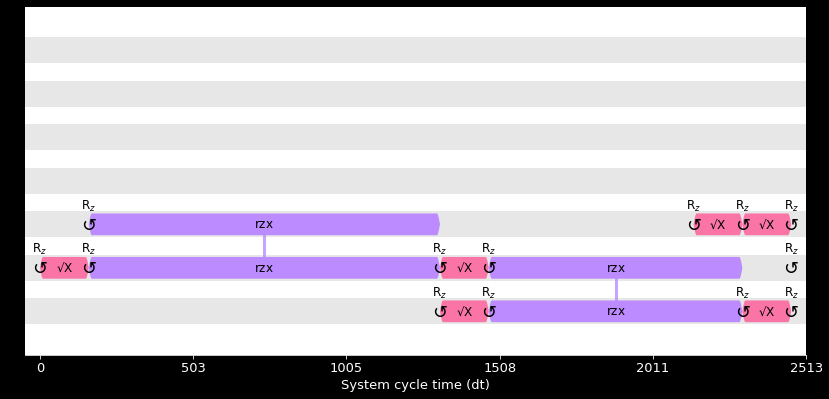

In [23]:
timeline_drawer(sca_circs_t_ddxy8[-1])

## `YGate`s Need Entry in `inst_sched_map`

Nick feels this should not be necessary and raised Terra Issue [#7400](https://github.com/Qiskit/qiskit-terra/issues/7400).

In [24]:
for qubit in range(backend_config.num_qubits):
    with pulse.build('y gate for qubit '+str(qubit)) as sched:
        # def of YGate() in terms of XGate() and phase_offset
        with pulse.phase_offset(np.pi/2, DriveChannel(qubit)): 
            x_gate = inst_sched_map.get('x', qubits=[qubit])
            pulse.call(x_gate)

        # for each DD sequence with a YGate() in it
        for circ in sca_circs_t_ddxy4+sca_circs_t_ddxy8:
            circ.add_calibration('y', [qubit], sched)

# Zero Noise Extraplotaion

Use [mitiq](https://mitiq.readthedocs.io/en/stable/guide/guide-zne.html) hahaha. <br>

What are the applications folks using?

# Measurement Error Mitigation

Use [mthree](https://qiskit.org/documentation/partners/mthree/), matrix-free measurment mitigation.